In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw
from IPython import display
from lib.viz import showarray

from stable_baselines import SAC
from stable_baselines.common.vec_env import VecNormalize
from stable_baselines.common.cmd_util import make_vec_env

import os
os.environ["MLFLOW_TRACKING_URI"] = "sqlite:///mlruns/db.sqlite"
import mlflow
mlflow_client = mlflow.tracking.MlflowClient()

from lib import eos
from lib.eos import EyeOnStickEnv
from lib.run import run_env_nsteps

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
#params = {
#        'REWARD_AIM_WEIGHT': 1,
#        'REWARD_LEVEL_WEIGHT': 0,
#        'REWARD_ACTION_WEIGHT': 0,
#        'GEAR_FUNC_NOISE': 0
#}

In [3]:
NJ = 3

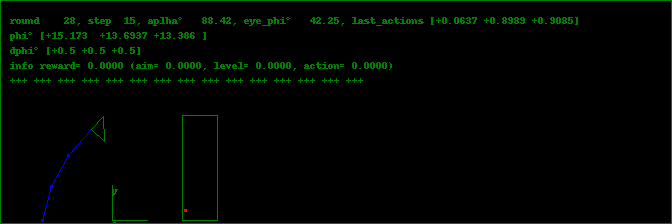

In [ ]:
model_name, model_version = "eos.3J", None
model, model_source = None, None

while True:
    if model_version is not None:
        registered_model = mlflow_client.get_model_version(model_name, model_version)
    else:
        registered_model = mlflow_client.get_latest_versions(model_name, stages=["None"])[0]
        
    #if model_source is None or model_source != registered_model.source:
    model_source = registered_model.source
    model = SAC.load(model_source)
        
    env = make_vec_env(lambda: EyeOnStickEnv(NJ, {}), n_envs=1)
    #env = VecNormalize(env)
    model.set_env(env)
    run_env_nsteps(env, model, 1000, display=display)
    
if False:
    obs = env.reset()
    for _ in range(200):
        actions = model.predict(obs)
        obs, _rewards, done, _info = env.step(actions)
        img_array = env.render(mode='rgb_array')

        # second screen
        from PIL import Image, ImageDraw
        image = Image.new('RGB', (eos.SCREEN_SIZE[0], 100))
        draw = ImageDraw.Draw(image)
        draw.text((10, 10), f"model name={registered_model.name} version={registered_model.version} source={registered_model.source}", fill=(0, 128, 0))
        img_array2 = np.asarray(image)

        # display both screens
        display.clear_output(wait=True)            
        showarray(np.vstack([img_array, img_array2]))
        
        if done:
            break